In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, probplot
from scipy.stats.stats import pearsonr
from IPython.display import display
import sys
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

In [155]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
test_df = pd.read_csv('data/test.csv', index_col='Id')

In [67]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [70]:
catCols = list(train_df.select_dtypes(include='object').columns)
print(f'Number of categorical variables: {len(catCols)}')
print(catCols)

Number of categorical variables: 43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [71]:
numCols = list(train_df.select_dtypes(include='number').columns)
print(f'Number of numerical variables: {len(numCols)}')
print(numCols)

Number of numerical variables: 36
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


Plot Phân phối SalePrice

C:\Users\HP 840 G4\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


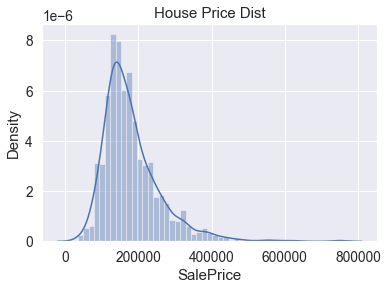

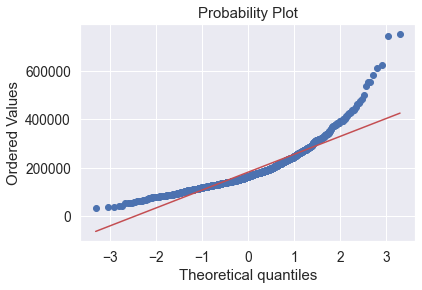

In [156]:
sns.distplot(train_df.SalePrice)
plt.title('House Price Dist');
fig = plt.figure()
res = probplot(train_df.SalePrice, plot=plt)

Nhận xét: SalePrice có dạng hơi lệch khỏi phân phối chuẩn một chút về bên phải

Chuẩn hóa đưa SalePrice về dạng normal distribution

C:\Users\HP 840 G4\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


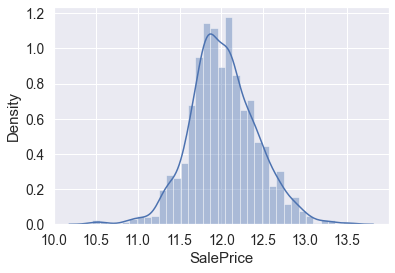

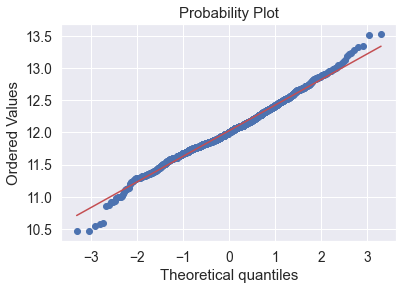

In [157]:
y_train = np.log(train_df.SalePrice)
sns.distplot(y_train)
fig = plt.figure()
res = probplot(y_train, plot=plt)

### Ma trận tương quan

<AxesSubplot:>

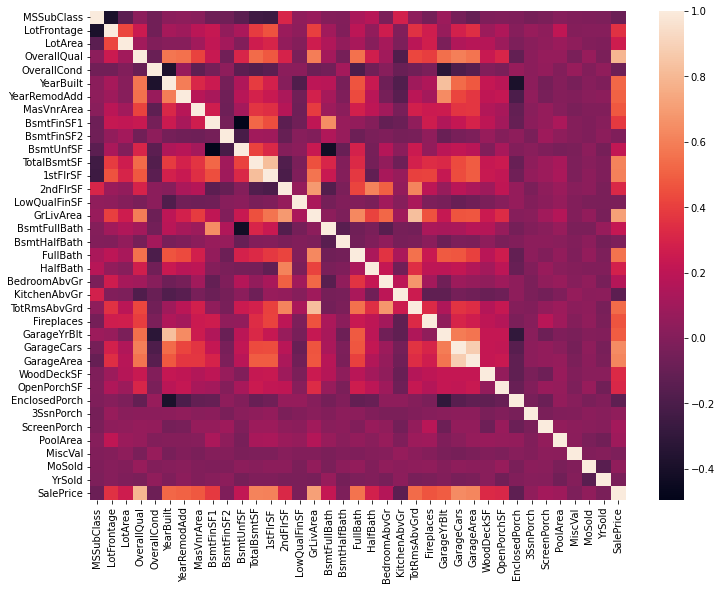

In [35]:
corr = train_df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr)

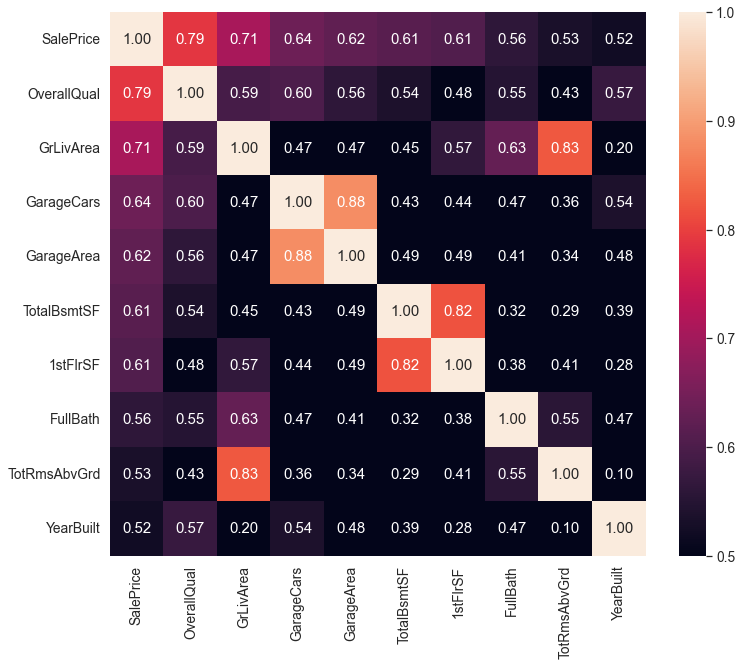

In [53]:
# 10 đặc trưng có độ tương quan lớn nhất với SalePrice
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(12,10))
# Select correlations greater than 0.5
hm = sns.heatmap(cm, annot=True,fmt='.2f', yticklabels=cols.values, xticklabels=cols.values, vmin = 0.5, vmax=1.)
plt.show();

Nhận xét:
* OverallQual, GrLivArea, TotalBsmtSF tương quan nhiều với SalePrice.
* GarageCars và GarageArea khá tương đồng nhau vì diện tích Garage càng lớn thì càng để được nhiều Oto, và ngược lại, nên có thể bỏ 1 cái, giữ lại GarageCars vì có độ tương đồng với SalePrice lớn hơn.
* TotalBsmtSF và 1stFlrSF cũng khá tương đồng nhau, giữ lại TotalBsmtSF
* FullBath: Không đóng vai trò lớn trong việc quyết định giá nhà.
* TotRmsAbvGrd và GrLivArea: giá tương đồng nhau --> bỏ TotRmsAbvGrd
* Giữ lại YearBuilt: vì quan trọng trong việc quyết định giá nhà.

### PLot những đặc trưng có độ tương quan cao với SalePrice

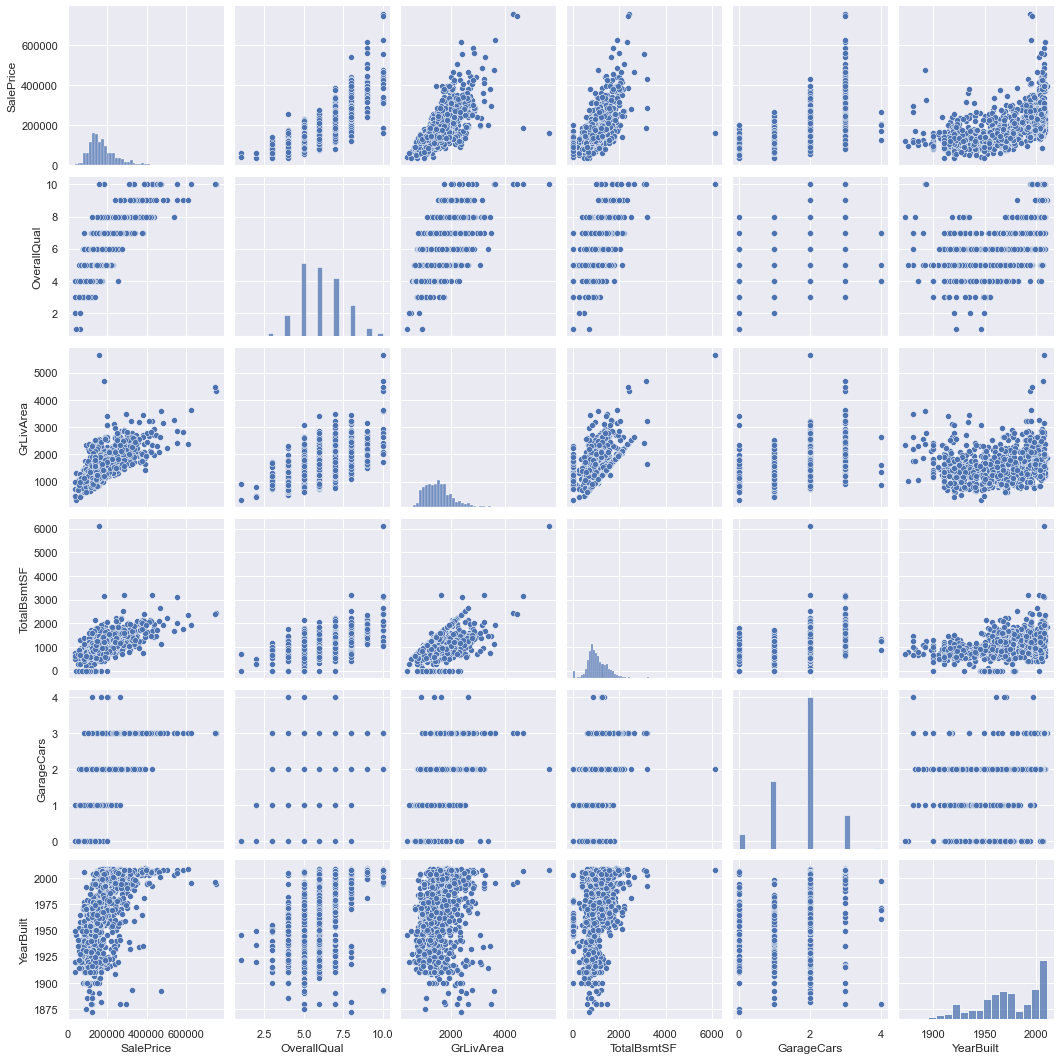

In [103]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt']
sns.pairplot(train_df[cols])
plt.show();

### Missing Values

In [158]:
missing_data_count_train = train_df.isna().sum()
missing_data_percent_train = missing_data_count_train / len(train_df) *100
missing_data_train = pd.DataFrame({
    'Count': missing_data_count_train,
    'Percent': missing_data_percent_train
})
missing_data_train = missing_data_train[missing_data_train.Count > 0]
missing_data_train.sort_values(by='Count', ascending=False, inplace=True)
print('There are {} features that have missing values'.format(len(missing_data_train.index)))
missing_data_train.head(19)

There are 19 features that have missing values


,Count,Percent
PoolQC,1453,99.521
MiscFeature,1406,96.301
Alley,1369,93.767
Fence,1179,80.753
FireplaceQu,690,47.260
LotFrontage,259,17.740
GarageType,81,5.548
GarageYrBlt,81,5.548
GarageFinish,81,5.548
GarageQual,81,5.548


### Data preprocessing & Feature Engineering

<b>Có 19 đặc trưng bị thiếu data </b>
Chia làm 3 group dựa theo file mô tả data
* Group 1: Đặc trưng dạng categorical : PoolQC, MiscFeature, Alley, Fence, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, BsmtExposure, BsmtFinType2, BsmtFinType1, BsmtCond, BsmtQual, MasVnrType <br>

    - Nhóm này thay giá trị NA bằng 'None'.

* Group 2: Đặc trưng dạng Numerical: MasVnrArea <br>

    - Nhóm này thay giá trị NA bằng 0

* Group 3: Các biến còn lại: LotFrontage, Electrical, GarageYrBlt
    - Ở Electrical thay NA bằng giá trị phổ biến nhất.
    - Ở LotFrontage thay thế bằng gía trị mean của cột đó.
    - Ở GarageYrBlt thay bằng giá trị của YearBuilt.
    

In [159]:
from sklearn.impute import SimpleImputer

# Group 1:
group_1 = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrType']

train_df[group_1] = train_df[group_1].fillna('None')

# Group 2:
group_2 = ['MasVnrArea']
train_df[group_2] = train_df[group_2].fillna(0)

# Group 3:
group_3a = ['Electrical']
imputer = SimpleImputer(strategy='most_frequent')
train_df[group_3a] = pd.DataFrame(imputer.fit_transform(train_df[group_3a]), index=train_df.index)

train_df.LotFrontage = train_df.LotFrontage.fillna(train_df.LotFrontage.mean())
train_df.GarageYrBlt = train_df.GarageYrBlt.fillna(train_df.YearBuilt)

In [160]:
train_df.isna().sum().sum()

0

In [161]:
# Chuẩn hóa SalePrice
from sklearn.preprocessing import StandardScaler
y_train_scaled = StandardScaler().fit_transform(train_df.SalePrice.values.reshape(-1,1))
y_train_scaled


array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ...,
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

#### Outliers

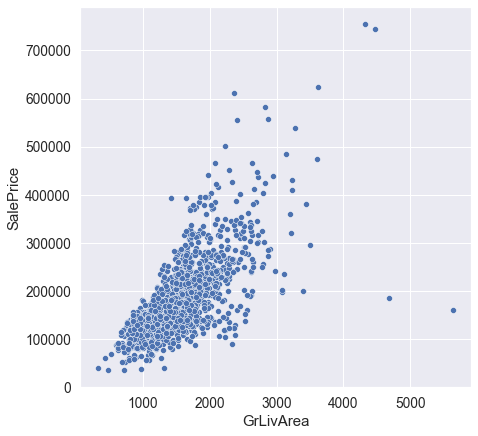

In [162]:
# Xem mối quan hệ giữa GrLivArea và SalePrice
fg = plt.figure(figsize=(7,7))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice']);

<b>Nhận xét: 2 điểm ở góc phải bên dưới khá khác biệt so với các điểm còn lại, đi ngược lại xu hướng, nên khả năng rất cao đây là 2 điểm ngoại lai </b> <br>
<b> --> Nên ta sẽ loại bỏ chúng </b>

In [170]:
outlier_index = train_df[(train_df.GrLivArea > 4000) & (train_df.SalePrice < 200000)].index
train_df.drop(outlier_index,axis=0, inplace=True)

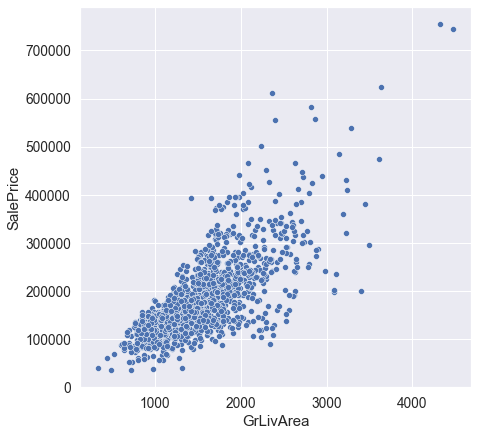

In [171]:
# Xem mối quan hệ giữa GrLivArea và SalePrice sau khi đã bỏ outliers
fg = plt.figure(figsize=(7,7))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice']);

#### Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
